In [108]:
using IonSim
using QuantumOptics
using QuantumOptics: timeevolution, stochastic

In [109]:
import DifferentialEquations
import PyPlot
const plt = PyPlot

PyPlot

In [110]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [111]:
C = Ca40(["S-1/2", "D-1/2"])

⁴⁰Ca


In [112]:
L = Laser()

Laser(IonSim.var"#Et#24"{Int64}(0), 0, (x = 0.7071067811865475, y = 0.7071067811865475, z = 0.0), (x = 0, y = 0, z = 1), IonSim.var"#ϕt#25"{Int64}(0), 7.29147e-7, Tuple{Int64, Real}[])

In [113]:
chain = LinearChain(
        ions=[C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
        vibrational_modes=(x=[], y=[], z=[1]))

LinearChain(1 ions)

In [114]:
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);

In [115]:
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /home/ion/.julia/packages/IonSim/5Hvou/src/lasers.jl:84


In [116]:
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L.Δ = Δf

2.239399193848153e6

In [117]:
Efield_from_pi_time!(2e-6, T, 1, 1, ("S-1/2", "D-1/2"));  # Sets pi_time to 2 μs

In [118]:
mode = T.configuration.vibrational_modes.z[1]

VibrationalMode(ν=1.0e6, axis=ẑ, N=10)

### Rapid Adiabatic Passage on carrier transition

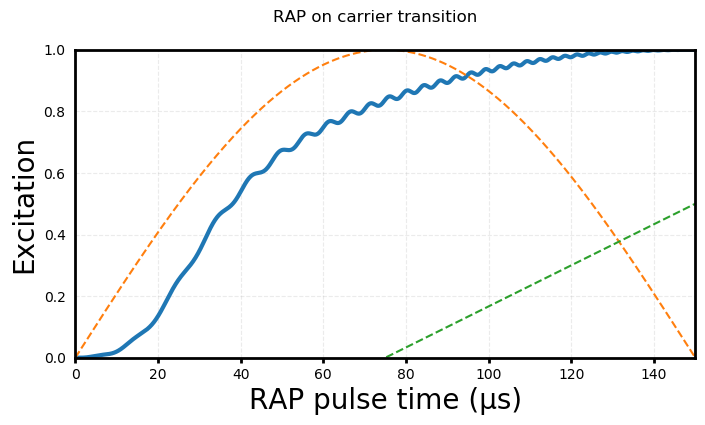

  0.072395 seconds (591.50 k allocations: 12.795 MiB, 56.04% gc time)


PyObject Text(0.5, 0.98, 'RAP on carrier transition')

In [119]:
# the length of time of the frequency chirp in μs
Tp = 150

#detuning range, this is the chirp width 
δν = 300e3

# Δϕ is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
Δϕ = 2π * (δν/2) * 1e-6

# Set the frequency chirp

# function Φ(t)
#     if t < Tp
#         return cos(π*t/Tp)
#     else
#         return 0
#     end
# end

L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;

# amplitude Rabi_freq
E = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

function Ω(t)
    if t < Tp
        return E*sin(π*t/Tp) #E*sin(π*t/Tp) #exp.(-(tspan.-Tp./2).^2)./(Tp.^2/36) 
    else
        return 0
    end
end
L.E = Ω;

# Set the B-field to match the value in the reference
T.B = 2.9e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))

L.Δ  = Δf # set detuning to carrier 

tspan = 0:0.1:Tp
h = hamiltonian(T, rwa_cutoff=1e5)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, C["S-1/2"] ⊗ mode[0], h)

ex = expect(ionprojector(T, "D-1/2"), sol)
plt.plot(tout, ex, lw=3)
plt.plot(
        tout, @.(L.E(tout) / E), 
        linestyle="--", label="amplitude profile"
    )
plt.plot(
        tout, @.(L.ϕ(tout) / (2Δϕ * tout)), 
        linestyle="--", label="frequency profile"
    )
plt.xlim(tout[1], tout[end])
#plt.legend(loc=1)
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("RAP pulse time (μs)")
plt.suptitle("RAP on carrier transition")

## RAP on sideband transition

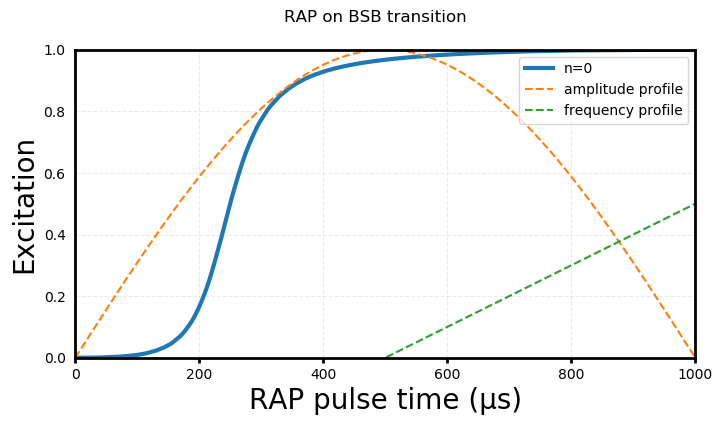

  0.133281 seconds (2.57 M allocations: 57.403 MiB)


PyObject Text(0.5, 0.98, 'RAP on BSB transition')

In [133]:
# the length of time of the frequency chirp in μs
Tp = 1000

#detuning range, this is the chirp width 
δν = 300e3

# Δϕ is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
Δϕ = 2π * (δν/2) * 1e-6

# Set the frequency chirp
# function Φ(t)
#     if t < Tp
#         return cos(π*t/Tp)
#     else
#         return 0
#     end
# end
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;

# amplitude Rabi_freq
E = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

function Ω(t)
    if t < Tp
        return 5*E*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
#     elseif Tp <= t <= 2*Tp
#         return 10*E*sin(π*t/Tp)
    else
        return 0
    end
end
L.E = Ω;

# Set the B-field to match the value in the reference
T.B = 2.9e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))

L.Δ  = Δf + mode.ν - 0e5# tune laser frequency to blue sideband

tspan = 0:0.1:Tp
ψ_in = C["S-1/2"] ⊗ mode[0]
h = hamiltonian(T, rwa_cutoff=1e5)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ_in, h)

ex = expect(ionprojector(T, "D-1/2"), sol)

plt.plot(tout, ex, lw=3, label = "n=0")

#p = twinx()
plt.plot(
      tout, @.(L.E(tout) / 5E), 
        linestyle="--", label="amplitude profile"
    )
plt.plot(
        tout, @.(L.ϕ(tout) / (2Δϕ * tout)), 
        linestyle="--", label="frequency profile"
    )
plt.xlim(tout[1], tout[end])
plt.legend(loc=1)
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("RAP pulse time (μs)")
plt.suptitle("RAP on BSB transition")

## Calculate fidelity

In [145]:
real(expect(ionprojector(T, "S-1/2"), sol[end]))

3.194608376102932e-7

In [149]:
thermalstate(mode, 10)

Operator(dim=11x11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 0.139966  0.0       0.0       0.0       …  0.0        0.0        0.0
 0.0       0.127242  0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.115675  0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.105159     0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0652954  0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0593595  0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0539631

### finite temperature effect

 32.255254 seconds (87.85 M allocations: 2.010 GiB, 72.60% gc time)
  6.731956 seconds (38.10 M allocations: 1.008 GiB, 4.72% gc time, 7.75% compilation time)


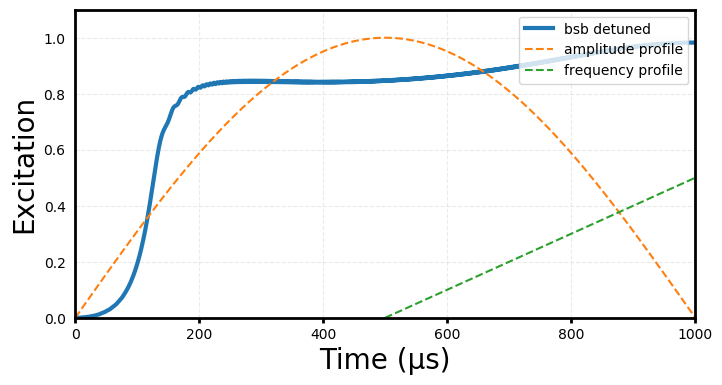

In [38]:
ψi_ion = dm(C["S-1/2"]) 
mode.N = 20
ψi_mode = thermalstate(mode, 10)
ψi = ψi_ion ⊗ ψi_mode

# the length of time of the frequency chirp in μs
Tp = 1000

#detuning range 
δν = 300e3

# Δϕ is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
Δϕ = 2π * (δν/2) * 1e-6

# Set the frequency chirp
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;

E = Efield_from_pi_time(2e-6, T, 1, 1, ("S-1/2", "D-1/2"))

function Ω(t)
    if t < Tp
        return 4*E*sin(π*t/Tp)
    else
        return 0
    end
end

L.E = Ω


# Set the B-field to match the value in the reference
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))

L.Δ  = Δf + mode.ν - 0e3 # tune laser frequency to blue sideband 

tspan = 0:0.1:Tp
h = hamiltonian(T, timescale=1e-6, rwa_cutoff=1e4, time_dependent_eta=false, displacement="truncated")
@time tout, sol_bsb = timeevolution.schroedinger_dynamic(tspan, ψi, h)

E = Efield_from_pi_time(2e-6, T, 1, 1, ("S-1/2", "D-1/2"))

function Ω(t)
    if t < Tp
        return E*sin(π*t/Tp)
    else
        return 0
    end
end

L.E = Ω

L.Δ  = Δf # tune laser frequency to carrier 

tspan = 0:0.1:Tp
h = hamiltonian(T, timescale=1e-6, rwa_cutoff=1e4, time_dependent_eta=false, displacement="truncated")
@time tout, sol_car = timeevolution.schroedinger_dynamic(tspan, ψi, h)


ex_bsb = expect(ionprojector(T, "D-1/2"), sol_bsb)
ex_car = expect(ionprojector(T, "D-1/2"), sol_car)
plt.plot(tout, ex_bsb, lw=3, label="bsb detuned")
#plt.plot(tout, ex_car, lw=3, label="carrier")

plt.plot(
        tout, @.(L.E(tout) / E), 
        linestyle="--", label="amplitude profile"
    )
plt.plot(
        tout, @.(L.ϕ(tout) / (2Δϕ * tout)), 
        linestyle="--", label="frequency profile"
    )
plt.xlim(tout[1], tout[end])
plt.legend(loc=1)
plt.ylim(0, 1.1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

In [21]:
η = get_η(mode, L, C)

0.06852224350584407

In [22]:
?get_η(mode, L, C)

```
get_η(V::VibrationalMode, L::Laser, I::Ion)
```

The Lamb-Dicke parameter:  $|k|cos(\theta)\sqrt{\frac{\hbar}{2m\nu}}$  for a given vibrational mode, ion and laser.


In [23]:
1/0.068

14.705882352941176

In [139]:
mode[5]

Ket(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im